## Kaggle: Creditcard
- source: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
- github repository:


About Dataset

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

Acknowledgements from Kaggle

The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.
More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project



In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
import warnings

import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import gaussian_kde
from sklearn.metrics import silhouette_score, silhouette_samples,davies_bouldin_score, calinski_harabasz_score
#!pip install clusteval
from collections import defaultdict
#warnings.simplefilter("ignore", category=DeprecationWarning)
#warnings.simplefilter("ignore", category=FutureWarning)

In [164]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [165]:
# Load dataset
df2 = pd.read_csv('/content/drive/MyDrive/creditcard.csv')

df2.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [166]:
df2.shape

(284807, 31)

In [167]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [168]:
#Removing duplicates
print(len(df2[df2.duplicated()]))
df2.drop_duplicates(keep='last',inplace=True)

# Handle missing values
df2.dropna(inplace=True)


1081


In [169]:
credit_card_time_df = df2.drop(['Class'],axis=1,inplace=False)
credit_card_df = credit_card_time_df.copy()

In [170]:
from datetime import datetime, timedelta
# Define the starting timestamp (September 1, 2013)
start_date = datetime(2013, 9, 1)

# Convert elapsed seconds in "Time" to actual datetime values
#credit_card_time_df['Datetime'] = credit_card_time_df['Time'].apply(lambda x: start_date + timedelta(seconds=x))

# Extract useful time features
#credit_card_time_df['Day'] = credit_card_time_df['Datetime'].dt.day
#credit_card_time_df['Hour'] = credit_card_time_df['Datetime'].dt.hour
#credit_card_time_df['Minute'] = credit_card_time_df['Datetime'].dt.minute

In [171]:
#credit_card_df = credit_card_time_df.drop(['Datetime'],axis=1,inplace=False)
credit_card_df.columns


Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

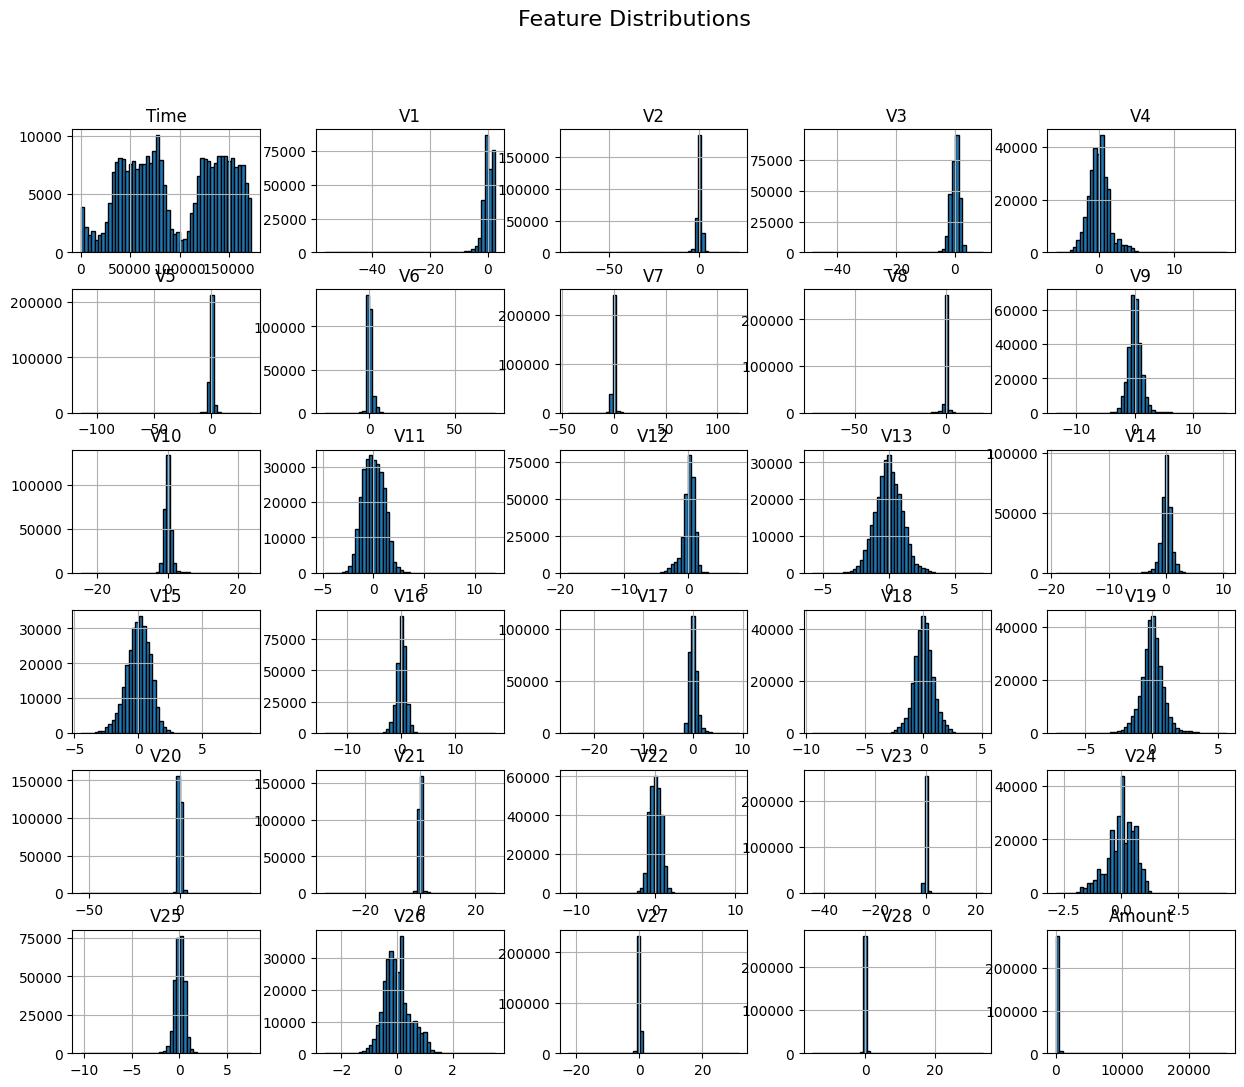

In [172]:
credit_card_df.hist(figsize=(15, 12), bins=50, edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()



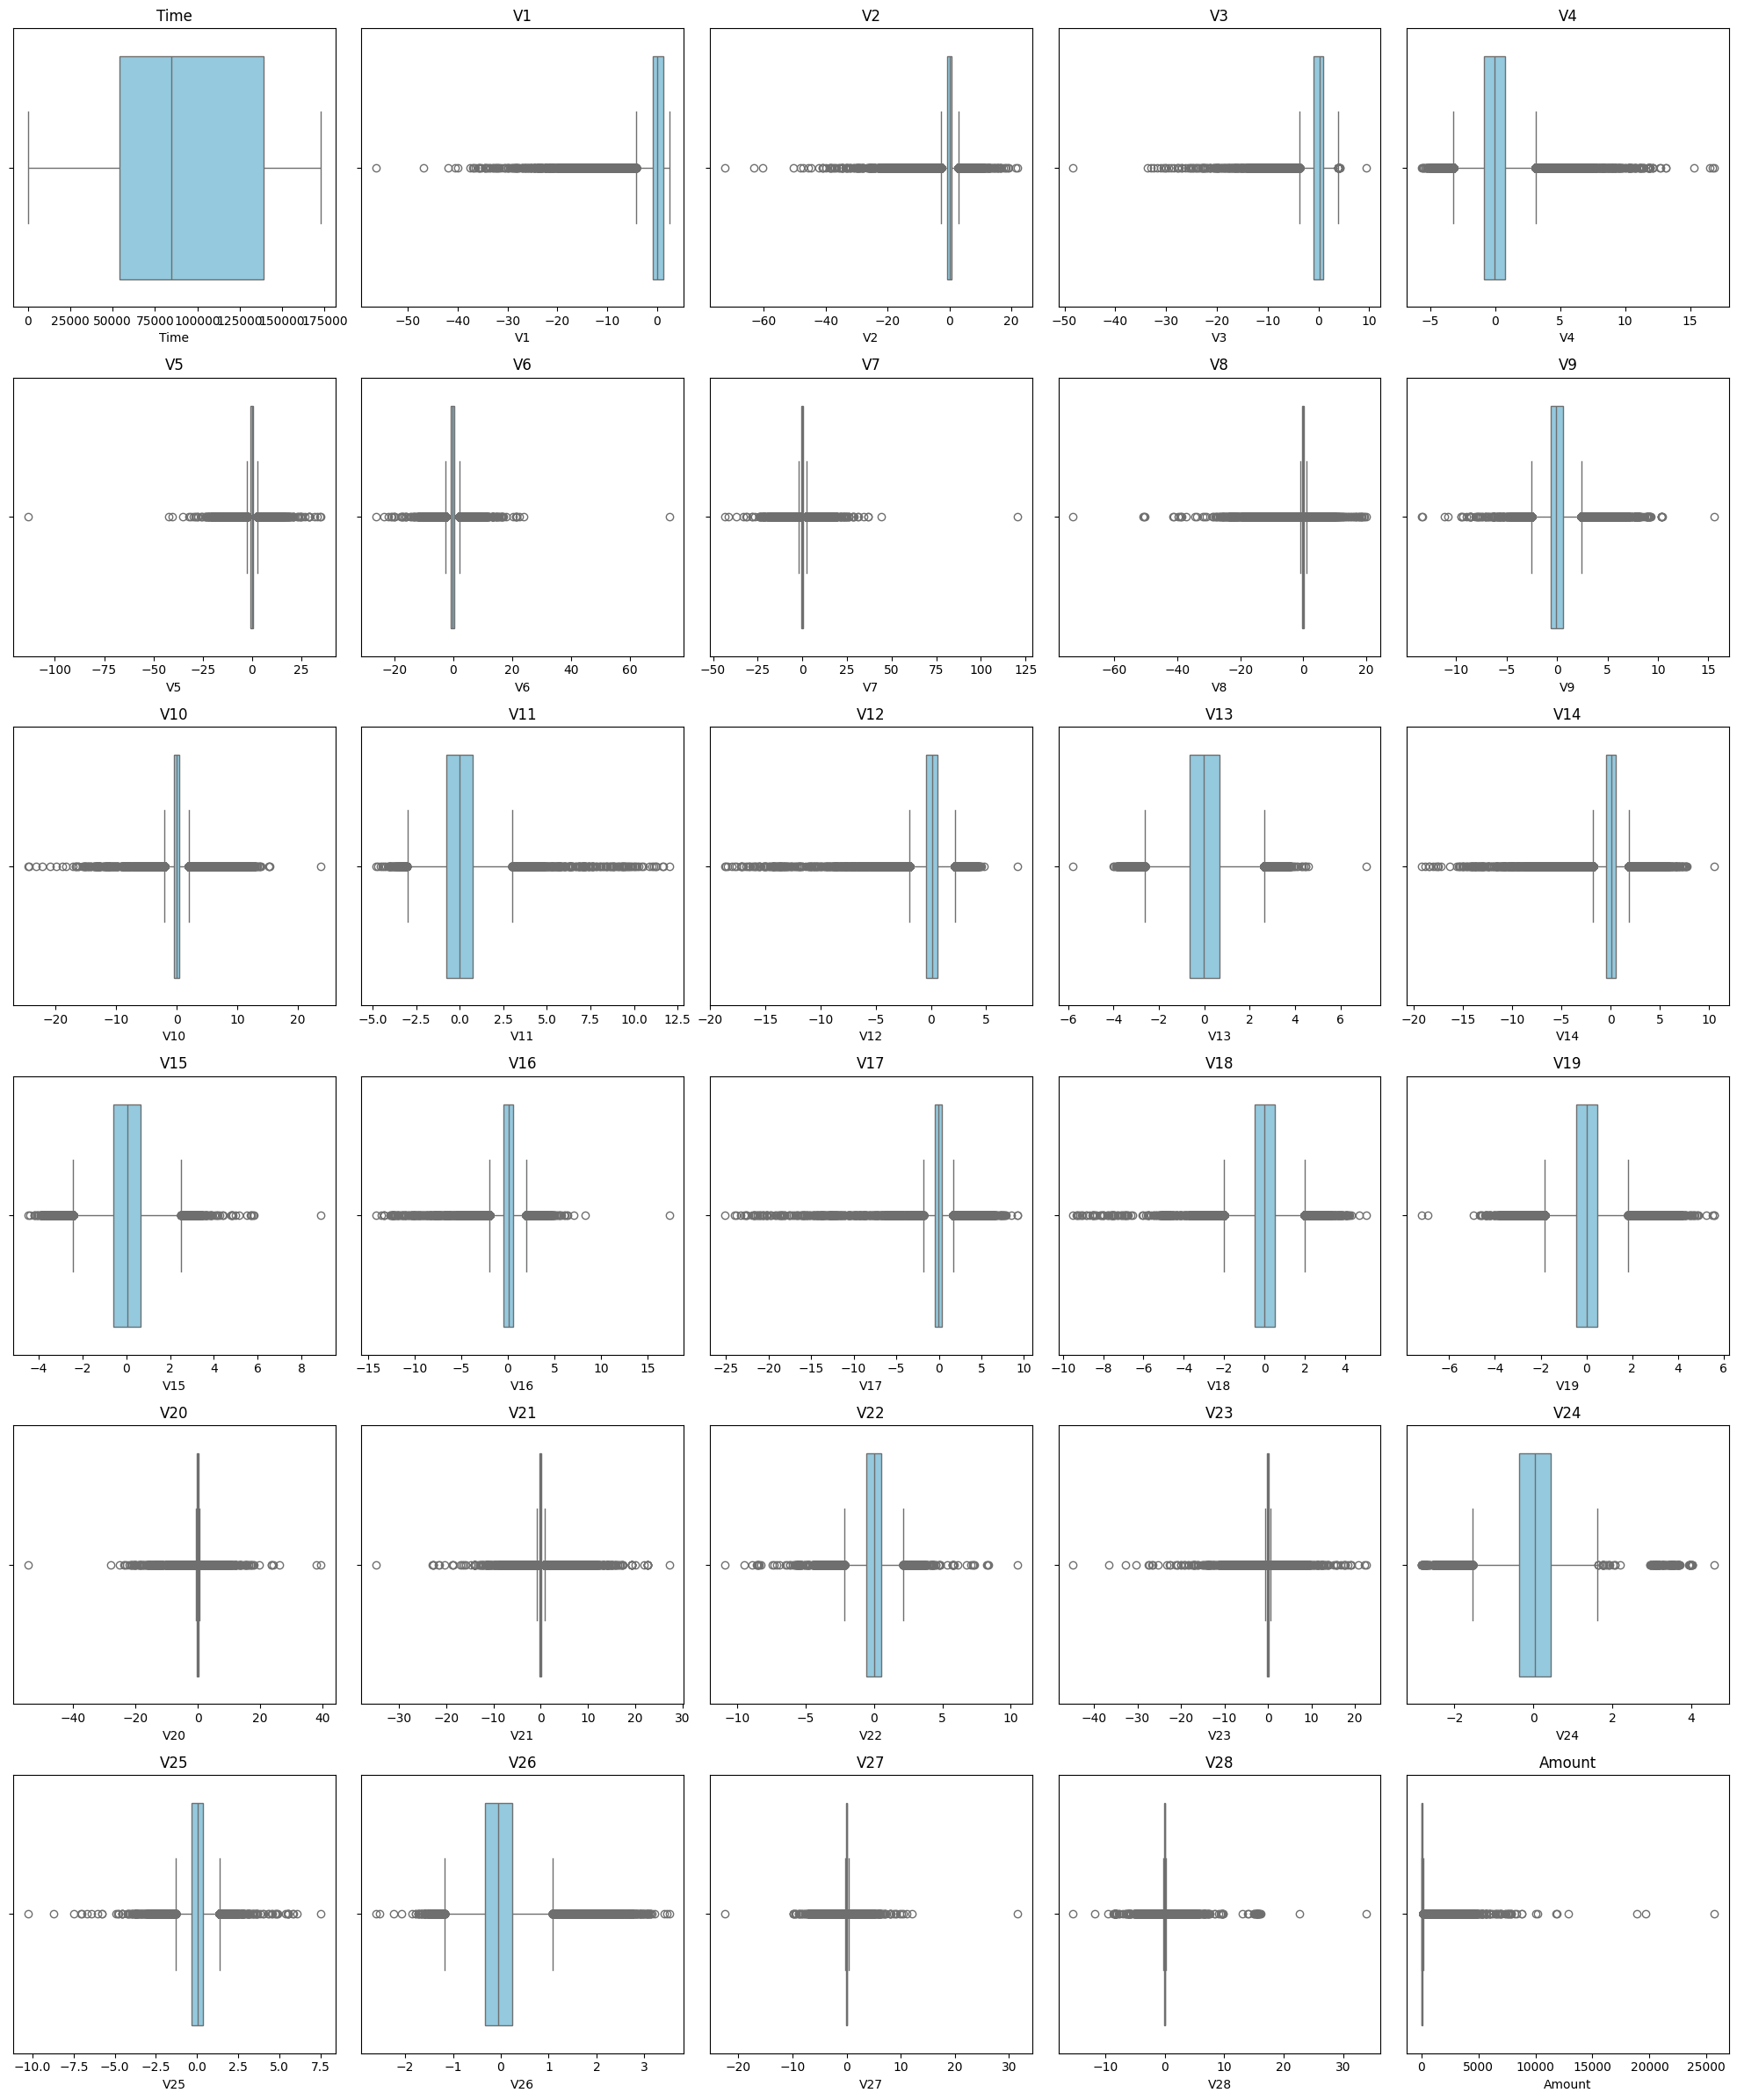

In [173]:
def boxplot_grid(df, num_cols=5):
    """Plots boxplots for numerical features, 5 per row."""
    import seaborn as sns
    import matplotlib.pyplot as plt

    num_features = df.select_dtypes(include=['number']).columns
    num_rows = -(-len(num_features) // num_cols)  # Ceiling division

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4))
    axes = axes.flatten()

    for i, feature in enumerate(num_features):
        sns.boxplot(x=df[feature].dropna(), ax=axes[i], color='skyblue')
        axes[i].set_title(f'{feature}')

    for j in range(i + 1, len(axes)): fig.delaxes(axes[j])  # Remove unused subplots

    plt.tight_layout()
    plt.show()

boxplot_grid(credit_card_df)


In [201]:
#stratisfied sampling based on Time
def stratified_sampling(df, sample_size=0.1, random_state=42):
    """
    Perform stratified sampling on the dataset based on the time feature to maintain its distribution.

    Parameters:
        df (DataFrame): The dataset containing a 'Time' column.
        sample_size (float): The fraction of the dataset to sample (default: 10%).
        random_state (int): Random seed for reproducibility.

    Returns:
        DataFrame: A stratified sampled subset of the original dataset.
    """
    df['Time_Bin'] = pd.qcut(df['Time'], q=10, duplicates='drop')  # Create bins based on time distribution
    df_sampled = df.groupby('Time_Bin').apply(lambda x: x.sample(frac=sample_size, random_state=random_state))
    return df_sampled.drop(columns=['Time_Bin'])  # Remove bin column after sampling

# Apply stratified sampling
df_sampled = stratified_sampling(credit_card_df, sample_size=0.05)
df_sampled.head(4)

Time        V1        V2        V3        V4  \
Time_Bin                                                                   
(-0.001, 35028.0] 22546  32299.0  1.325993 -0.656340  0.589984 -0.510538   
                  26403  34049.0  1.291782 -1.445020  0.696149 -1.497140   
                  2341    1882.0  1.317470 -0.040713  0.032014 -0.374985   
                  20487  31075.0  1.359117 -1.356784  1.177912 -1.266866   

                               V5        V6        V7        V8        V9  \
Time_Bin                                                                    
(-0.001, 35028.0] 22546 -1.207532 -0.622590 -0.685685  0.000177 -0.622656   
                  26403 -1.602733  0.221452 -1.416433  0.207175 -1.731385   
                  2341  -0.181072 -0.370094 -0.158119 -0.025468  0.080709   
                  20487 -2.022342 -0.101043 -1.567829  0.085887 -1.527940   

                         ...       V20       V21       V22       V23  \
Time_Bin                 ...                                           
(-0.001, 35028.0] 22546  ...  0.020577  0.039515  0.127081 -0.016896   
                  26403  ... -0.222972 -0.144840 -0.216367  0.044970   
                  2341   ... -0.049134 -0.116096 -0.354175 -0.064966   
                  20487  ... -0.201977  0.026912  0.547038 -0.073850   

                              V24       V25       V26       V27       V28  \
Time_Bin                                                                    
(-0.001, 35028.0] 22546  0.558328  0.477295 -0.273222  0.005234  0.004760   
                  26403 -0.365012  0.054109 -0.268957  0.051688  0.026158   
                  2341  -0.442757  0.314108  0.995446 -0.089684 -0.015753   
                  20487  0.360748  0.329406 -0.068139  0.070616  0.027786   

                         Amount  
Time_Bin                         
(-0.001, 35028.0] 22546   15.00  
                  26403   82.22  
                  2341     0.77  
                  20487   44.95  

[4 rows x 30 columns]

In [202]:
df_sampled.shape

(14190, 30)

In [203]:
# Standardize numerical features
scaler = StandardScaler()
df2_pca_scaled = scaler.fit_transform(df_sampled.select_dtypes(include=[np.number]))

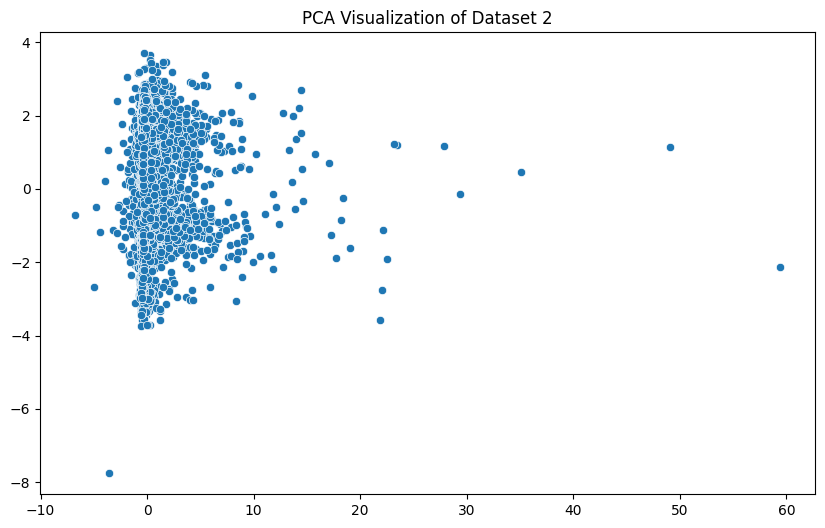

In [204]:
#Dimensionality Reduction using PCA
pca = PCA(n_components=3)
df2_pca = pca.fit_transform(df2_pca_scaled)

# Visualize Dataset_2 PCA Results
plt.figure(figsize=(10,6))
sns.scatterplot(x=df2_pca[:, 0], y=df2_pca[:, 1])
plt.title("PCA Visualization of Dataset 2")
plt.show()

### Denclue Implementation

In [205]:
# Gaussian Kernel function for d-dimensional data
def gaussian_kernel(z, d):
    return (2*np.pi)**(d/2)* np.exp(-0.5 * np.linalg.norm(z, axis=1) ** 2)

def density_estimation_f(x,D,h):
    n = D.shape[0]
    d = D.shape[1]

    return 1/(n*(h**d))*np.sum(gaussian_kernel((x - D) / h, d))

# FindAttractor function for d-dimensional data
def find_attractor(x, D, h, epsilon=1e-3, max_iter=1000):
    x_t = np.array(x, dtype=float)
    d = D.shape[1]  # Get dimensionality


    for t in range(max_iter):
        # Compute distances and weights
        z = (x_t - D) / h

        #weights is an array
        weights = gaussian_kernel(z, d)

        # Compute density-weighted mean
        numerator = np.sum(weights[:, np.newaxis] * x_t, axis=0)
        denominator = np.sum(weights)

        x_t_next = numerator/denominator  if denominator != 0 else x_t

        # Convergence check
        if np.linalg.norm(x_t_next - x_t) <= epsilon:
            x_t = x_t_next
            break
        x_t = x_t_next

    return x_t  # Round to avoid floating-point precision errors

import numpy as np
from scipy.spatial.distance import cdist

def find_density_connected_components(attractors, epsilon):
    """
    Identifies maximal density-connected clusters in DENCLUE.

    Parameters:
        attractors: np.ndarray (n, d) - Converged attractor points
        epsilon: float - Maximum distance for density reachability

    Returns:
        clusters: list of lists - Each list contains indices of points in the same cluster
    """
    n = len(attractors)
    visited = np.zeros(n, dtype=bool)  # Track visited points
    clusters = []  # Store clusters

    def density_reachable(idx, cluster):
        """Recursively find density-reachable points."""
        visited[idx] = True
        st = [idx]
        while st:
            current = st.pop()
            cluster.append(current)
            neighbors = np.where(cdist([attractors[current]], attractors)[0] <= epsilon)[0]
            for neighbor in neighbors:
                if visited[neighbor]:
                    continue

                visited[neighbor] = True
                st.append(neighbor)

    for i in range(n):
        if not visited[i]:
            new_cluster = []
            density_reachable(i, new_cluster)
            if len(new_cluster) > 1:  # Ensure meaningful clusters
                clusters.append(new_cluster)

    return clusters


def refine_clusters(clusters, attractors, R, epsilon):
    """
    Expands density-based clusters by ensuring all reachable points are included.

    Parameters:
        clusters: list of lists - Initial clusters with density-connected points
        attractors: np.ndarray (n, d) - Attractor points
        epsilon: float - Maximum distance for density reachability

    Returns:
        refined_clusters: list of lists - Expanded clusters
    """
    for cluster in clusters:
        expanded_cluster = set(cluster)  # Convert to set for efficient merging

        # Iterate through all points in the cluster
        for idx in list(expanded_cluster):
            # Find all points within epsilon distance
            # neighbors = np.where(cdist([attractors[idx]], attractors)[0] <= epsilon)[0]
            expanded_cluster.update(R[tuple(attractors[idx])])  # Merge density-reachable points

        cluster[:] = list(expanded_cluster)  # Update cluster in place

    return clusters


def denclue(D, h, density_threshold, epsilon=1e-3):
    A = set() #set
    R = defaultdict(set) #dict
    clusters = {}
    labels = np.full(len(D), -1)  # Initialize all points as noise (-1)
    d = D.shape[1]  # Get dimensionality

    for idx, x in enumerate(D):
        x_star = find_attractor(x, D, h, epsilon)

        if density_estimation_f(x_star,D,h) >=density_threshold:
            A.add(tuple(x_star))
            R[tuple(x_star)].add(idx)

    A = np.array(list(A))
    C = find_density_connected_components(A,density_threshold)
    C = refine_clusters(C, A, R, density_threshold)
    L = assign_labels(D,C)
    return C, L


def assign_labels(D, clusters):
    """
    Assigns cluster labels to each attractor point.

    Parameters:
        attractors: np.ndarray (n, d) - Attractor points
        clusters: list of lists - Clustered point indices

    Returns:
        labels: np.ndarray (n,) - Cluster labels for each point
    """
    labels = np.full(len(D), -1)  # Default: noise (-1)

    for cluster_id, cluster in enumerate(clusters):
        for idx in cluster:
            labels[idx] = cluster_id  # Assign cluster ID

    return labels

def plot_scatter_kde(x_grid,kde_values,x_values,bandwidth):
    plt.figure(figsize=(8, 4))
    plt.plot(x_grid, kde_values, 'k-', linewidth=1)  # Density curve
    plt.scatter(x_values, np.zeros_like(x_values), color='blue')  # Data points at bottom
    plt.xlabel("")
    plt.ylabel("f(x)")
    plt.title("Density Estimation h = "+str(bandwidth))

    plt.show()
# KDE Density Estimation for 3D Surface Plot
def plot_3DSurface(data,bandwidth):
    x_values, y_values = data[:, 0], data[:, 1]
    kde = gaussian_kde(np.vstack([x_values, y_values]), bw_method=bandwidth)

    x_grid, y_grid = np.meshgrid(np.linspace(min(x_values)-0.2, max(x_values)+0.5, 200),
                                 np.linspace(min(y_values)-0.2, max(y_values)+0.5, 200))
    z_values = kde(np.vstack([x_grid.ravel(), y_grid.ravel()])).reshape(x_grid.shape)

    # 3D Plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_values, y_values, np.zeros_like(x_values), color='blue')
    ax.plot_surface(x_grid, y_grid, z_values, edgecolor='gray', cmap='viridis')
    ax.set_xlabel("Component 1 (cm)")
    ax.set_ylabel("Component 2 (cm)")
    ax.set_zlabel("f(x)")
    ax.set_title("3D Density Estimation h = "+str(bandwidth))
    plt.show()

In [206]:
data = np.array(df2_pca, dtype=float)  # Ensure numerical format
print(len(data))

14190


In [207]:
# Denclue Parameters
bandwidth = 0.4 # Smoothness parameter #deacreasing bandwidth ->  Reduce  0.8
density_threshold = 0.7  # Minimum points per cluster #decreasing density_threshold -> Increase the number of clusters # 0.010

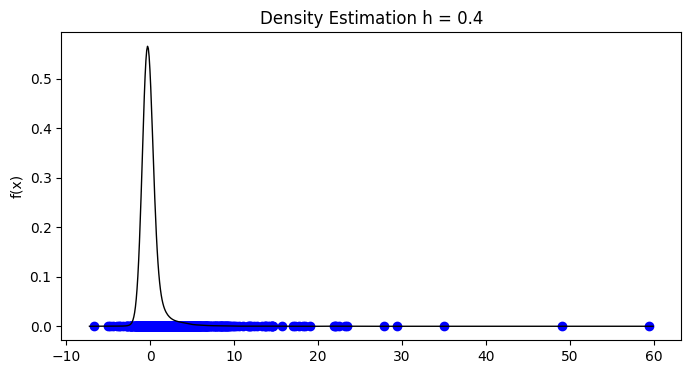

In [208]:
# KDE Density Estimation and Plot
x_values = data[:, 0]
y_values = data[:,1]
kde = gaussian_kde(x_values, bw_method=bandwidth)
x_grid = np.linspace(min(x_values) - 0.5, max(x_values) + 0.5, 700)
kde_values = kde(x_grid)
plot_scatter_kde(x_grid,kde_values,x_values,bandwidth)


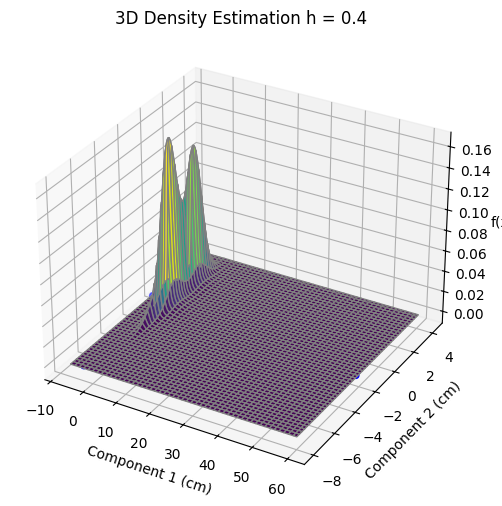

In [209]:
plot_3DSurface(data,bandwidth)

In [210]:
clusters,labels = denclue(data, bandwidth, density_threshold)

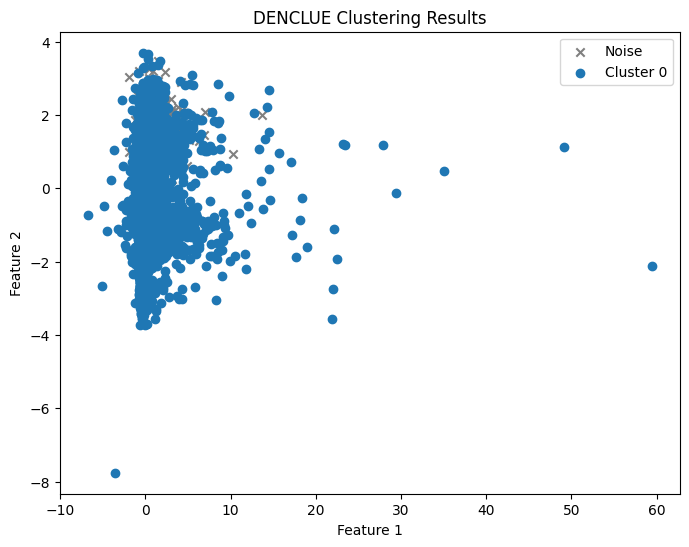

In [211]:
def plot_clusters(data, labels):
    """
    Plots the clusters from the given data and labels.

    Parameters:
    - data: numpy array of shape (n_samples, n_features)
    - labels: numpy array of shape (n_samples,)
    """
    unique_clusters = np.unique(labels)

    plt.figure(figsize=(8, 6))

    for cluster in unique_clusters:
        cluster_data = data[labels == cluster]

        if cluster == -1:
            plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label="Noise", c="gray", marker="x")
        else:
            plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f"Cluster {cluster}")

    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("DENCLUE Clustering Results")
    plt.legend()
    plt.show()
plot_clusters(data, labels)

### Tuning Denclue

In [223]:
# Function to tune parameters and store results in a table
def tune_denclue_parameters(data, bandwidth_values, density_threshold_values):
    results = []

    for h in bandwidth_values:
        for xi in density_threshold_values:
            clusters, labels = denclue(data, h, xi)

            # Convert clusters to labels
            #labels = np.full(len(data), -1)  # Initialize all points as noise (-1)
            #for cluster_id, points in enumerate(clusters):
            #    points_array = np.array([data[p] for p in points])
            #    for point in points_array:
            #        index = np.where((data == point).all(axis=1))[0]
            #        if index.size > 0:
            #            labels[index[0]] = cluster_id

            # Compute DBI
            try:
                dbi = davies_bouldin_score(data, labels)
            except:
                dbi = float('inf')  # Assign infinite DBI if computation fails

            results.append({"Bandwidth (h)": h, "Density Threshold (ξ)": xi, "Clusters Found": len(clusters), "DBI": dbi})

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Define parameter ranges for tuning
# bandwidth_values = [0.77,0.8,0.83]  # Different bandwidths to test
# density_threshold_values = [0.01,0.011,0.013]  # Different density thresholds to test
bandwidth_values = [0.2,0.4,0.6,0.8]  # Different bandwidths to test
density_threshold_values = [0.2,0.5,0.6]  # Different density thresholds to test

# Call the tuning function
results_df = tune_denclue_parameters(df2_pca, bandwidth_values, density_threshold_values)


In [224]:
results_df.sort_values(by='DBI', ascending=True).head(20)

,Bandwidth (h),Density Threshold (ξ),Clusters Found,DBI
11,0.8,0.6,1,1.129877
7,0.6,0.5,1,1.214861
8,0.6,0.6,1,1.252082
5,0.4,0.6,1,1.308806
4,0.4,0.5,1,1.326849
2,0.2,0.6,1,1.457948
1,0.2,0.5,2,2.391792
10,0.8,0.5,2,2.450763
6,0.6,0.2,134,13.264375
3,0.4,0.2,135,13.322695


In [ ]:
davies_bouldin_score(data, labels)

In [219]:
# Compute Silhouette Score
score = silhouette_score(data, labels)
print("Silhouette Score:", score)
# Compute Davies-Bouldin Index
dbi_score = davies_bouldin_score(data, labels)
print("Davies-Bouldin Index:", dbi_score)

# 0 to 1	Very good clustering (compact & well-separated).
# 1 to 2	Moderate clustering quality.
#>2	Poor clustering (overlapping, noisy, or poorly defined clusters).
# Unlike the Silhouette Score, DBI is not affected by noise points.
# Compute CH Index
ch_score = calinski_harabasz_score(data, labels)
print("Calinski-Harabasz Index:", ch_score)

#CH Index Value	Interpretation
#Low (e.g., < 100)	Poor clustering, clusters are not well-separated
#Moderate (100–1000)	Acceptable clustering quality
#High (1000+ or higher)	Strong clustering, well-separated groups

#The Gap Statistic is designed for clustering methods that use a fixed number
# of clusters (like K-Means). However, DENCLUE does not require pre-defining
# the number of clusters, which makes traditional Gap Statistic less effective.

Silhouette Score: 0.515605158864
Davies-Bouldin Index: 1.2995626071763784
Calinski-Harabasz Index: 127.0829755700495
